<a href="https://colab.research.google.com/github/vinodnbhat/AIML_CEP_2021/blob/main/VGG_Cifar10_TA_session_Nov04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imort the required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.optim.lr_scheduler as lr_scheduler

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
ROOT = '.data'

#downloading cifar10 dataset from torchvision.datasets
train_data = datasets.CIFAR10(root = ROOT, 
                             train = True, 
                             download = True)

mean = train_data.data.mean() / 255
std = train_data.data.std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .data/cifar-10-python.tar.gz to .data
Calculated mean: 0.4733630004850899
Calculated std: 0.2515689250632208


In [ ]:
print(train_data.data.shape)

(50000, 32, 32, 3)


In [ ]:
train_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [std])
                                     ])

In [ ]:
train_set = datasets.CIFAR10(root = ROOT, 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

test_set = datasets.CIFAR10(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(train_set.data.shape)

(50000, 32, 32, 3)


In [ ]:
print(test_set.data.shape)

(10000, 32, 32, 3)


In [ ]:
print(f'Number of training examples: {len(train_set)}')
print(f'Number of testing examples: {len(test_set)}')

Number of training examples: 50000
Number of testing examples: 10000


This dataset also contains 10 classes namely airplane, automobile, bird, cat,deer, dog, frog, horse, ship, truck, with 6000 images per class.

In [ ]:
batch_size = 64

#iterators for shuffling and loading data in batches 
train_loader = data.DataLoader(train_set, 
                               shuffle = True, 
                               batch_size = batch_size)

test_loader = data.DataLoader(test_set,
                              batch_size = batch_size)

In [ ]:
# Checking the batch dimensions 
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    # print (labels.shape[0])
    break

Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


In [ ]:
### Model settings###

# Hyperparameters
learning_rate = 0.01

# Architecture
num_classes = 10


<h2>VGG Net Architecture</h2>
<h3>Since our input image size is small, we can use fewer number of channels</h3>
<img src="https://1.bp.blogspot.com/-bHgaNqUKkR0/WarxZecuxbI/AAAAAAAATyk/7ABN8gZ-H7gdJ6sgU8rNYpR06LwMjWVTwCLcBGAs/s1600/The%2BVGG%2BNet%2BArchitecture%2B-%2BVGG16%2B-%2BHorizontal.png" alt="VGG NET" width="1024" height="515">                              

$\Large{\text{Summary of single convolution layer}:}$

**Input:** Image of size $W_1 \times H_1 \times D_1$.

**Hyperparameters:** K = number of filters, F = Filter size, S = number of strides, P = amount of zero padding. 

Note that the conventional values of $F, S$ and $P$ are 3, 1 and 1 respectively. However you are free to use any other numbers also. 

**Output:** Image of size $W_2 \times H_2 \times D_2$



*   $W_2 = \frac{W_1 - F + 2P}{S} + 1$,
*   $H_2 = \frac{H_1 - F + 2P}{S} + 1$,
*   $D_2 = K$.

**Number of shared weights:** 


*   Per filter weights = $F \times F \times D_1$,
*   weights for $K$ filters with bias = $(F \times F \times D_1)K + K$.

For more details, please refer to the following link:

[Convolution Neural Networks](https://cs231n.github.io/convolutional-networks/#layers)






In [ ]:
class VGG(nn.Module):  
    
    def two_conv_pool(self, in_channels, f1, f2):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        return s
    
    def three_conv_pool(self,in_channels, f1, f2, f3):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.Conv2d(f2, f3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        return s
    
    def __init__(self, num_classes=10):
        super(VGG, self).__init__()
        self.l1 = self.two_conv_pool(3, 16, 16)             #32x32x3 => 32x32x(f1=16) => 32x32x(f2=16) => 16x16x(f2=16) 
        self.l2 = self.two_conv_pool(16, 32, 32)            #16x16x16 => 16x16x(f1=32) => 16x16x(f2=32) => 8x8x(f2=32) 
        self.l3 = self.three_conv_pool(32, 64, 64, 64)      #8x8x32 => 8x8x64 => 8x8x64 => 8x8x64=> 4x4x64
        self.l4 = self.three_conv_pool(64, 64, 64, 64)      #4x4x64 => 4x4x64 => 4x4x64 => 4x4x64 => 2x2x64

        self.classifier = nn.Sequential(
            nn.Linear(64 * 2 * 2, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(32, num_classes),
        )
    
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        logits = x
        probas = F.log_softmax(x, dim=1)  
        return logits, probas

In [ ]:
# Initialize the model
model = VGG()
#_ = model.apply(init_weights)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 229,370 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
lossfn = nn.CrossEntropyLoss()

In [ ]:
if torch.cuda.is_available():
  print('cuda available! using cuda..')
else:
  print('cuda not available! using cpu..')    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cuda available! using cuda..


In [ ]:
model = model.to(device)
lossfn = lossfn.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred_logits, y_pred_probas = model(x)
        
        loss = lossfn(y_pred_logits, y)
        
        acc = calculate_accuracy(y_pred_probas, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred_logits, y_pred_probas = model(x)

            loss = lossfn(y_pred_logits, y)

            acc = calculate_accuracy(y_pred_probas, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
save_model = False
EPOCHS = 40

patience_early_stopping = 3  #training will stop if model performance does not improve for these many consecutive epochs
count = 0 #counter for checking patience level

prev_test_acc = 0 #initializing prev test accuracy for early stopping condition

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.2, patience = 1) #learning rate scheduler, update learning rate by 
#factor of 0.2 if test accuracy does not improve for patience+1 consecutive epochs

for epoch in range(EPOCHS):
    print("\nLearning rate for epoch {0}: {1}".format(epoch+1, optimizer.state_dict()['param_groups'][0]['lr']))
    start_time = time.perf_counter()
    
    train_loss, train_acc = train(model, train_loader, optimizer, lossfn, device)

    if save_model:
        torch.save(model.state_dict(), 'vgg_model.pt')
    
    if epoch%1==0: #for every epoch we shall compute the test accuracy
        test_loss, test_acc = evaluate(model, test_loader, lossfn, device)
        
        if test_acc > prev_test_acc: #check if test accuracy for current epoch has improved compared to previous epoch
          count = 0     #if accuracy improves reset counter to 0                   
        else:                        
          count += 1    #otherwise increment current counter

        prev_test_acc = test_acc

    
    scheduler.step(test_acc) #updates learning rate
    
    end_time = time.perf_counter()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    if epoch%1==0: #for every epoch we shall print the test loss and test accuracy 
        print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

    if count == patience_early_stopping:
      print(f"Early stopping as test accuracy did not improve for {patience_early_stopping} consecutive epochs")
      break


Learning rate for epoch 1: 0.001
Epoch:  1 | Epoch Time: 0m 44s
	Train Loss: 1.609 | Train Acc: 42.36%
	 Test Loss: 1.219 |  Test Acc: 57.68%

Learning rate for epoch 2: 0.001
Epoch:  2 | Epoch Time: 0m 43s
	Train Loss: 1.166 | Train Acc: 60.55%
	 Test Loss: 1.000 |  Test Acc: 64.72%

Learning rate for epoch 3: 0.001
Epoch:  3 | Epoch Time: 0m 42s
	Train Loss: 0.975 | Train Acc: 67.80%
	 Test Loss: 0.890 |  Test Acc: 70.22%

Learning rate for epoch 4: 0.001
Epoch:  4 | Epoch Time: 0m 43s
	Train Loss: 0.855 | Train Acc: 72.43%
	 Test Loss: 0.808 |  Test Acc: 72.90%

Learning rate for epoch 5: 0.001
Epoch:  5 | Epoch Time: 0m 44s
	Train Loss: 0.779 | Train Acc: 75.38%
	 Test Loss: 0.742 |  Test Acc: 74.77%

Learning rate for epoch 6: 0.001
Epoch:  6 | Epoch Time: 0m 43s
	Train Loss: 0.697 | Train Acc: 78.08%
	 Test Loss: 0.694 |  Test Acc: 77.70%

Learning rate for epoch 7: 0.001
Epoch:  7 | Epoch Time: 0m 43s
	Train Loss: 0.656 | Train Acc: 79.46%
	 Test Loss: 0.659 |  Test Acc: 78.75%

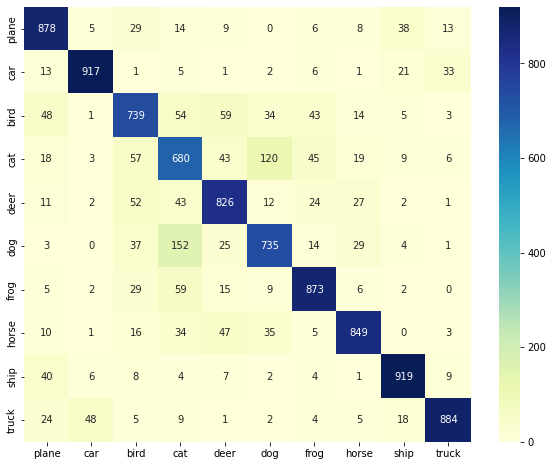

In [ ]:
## predictions of test images. The vertical line shows the true labels and horizontal line shows the predicted labels.


import pandas as pd
import seaborn as sns


classes = ['plane', 'car' , 'bird', 'cat', 'deer', 'dog','frog', 'horse', 'ship', 'truck'] 

heatmap = pd.DataFrame(data=0,index=classes,columns=classes)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        y_pred_logits, y_pred_probas = model(images)
        _, predicted = torch.max(y_pred_probas,1)
        c = (predicted == labels).squeeze()
        for i in range(labels.shape[0]):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label,predicted_label] += 1
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d",cmap="YlGnBu")
plt.show()
